In [14]:
!pip install pandas matplotlib seaborn -q

In [15]:
# 2. استيراد المكتبات
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



In [16]:

city_df = pd.read_excel('Dimension.City.xlsx')
customer_df = pd.read_excel('Dimension.Customer.xlsx')
employee_df = pd.read_excel('Dimension.Employee.xlsx')
stock_item_df = pd.read_excel('Dimension.Stock Item.xlsx')
sale_df = pd.read_excel('Fact.Sale.xlsx')

# عرض معلومات عامة عن البيانات
print("=== معلومات عن الملفات ===")
print(f"عدد المدن: {len(city_df)}")
print(f"عدد العملاء: {len(customer_df)}")
print(f"عدد الموظفين: {len(employee_df)}")
print(f"عدد الأصناف: {len(stock_item_df)}")
print(f"عدد المبيعات: {len(sale_df)}")

/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


=== معلومات عن الملفات ===
عدد المدن: 100
عدد العملاء: 100
عدد الموظفين: 100
عدد الأصناف: 100
عدد المبيعات: 100


/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [24]:
# إصلاح أسماء الأعمدة (إزالة الفراغات والرموز)
def clean_column_names(df):
    df.columns = [col.replace('\n', ' ').replace('\r', ' ').strip().replace(' ', '_') for col in df.columns]
    return df

city_df = clean_column_names(city_df)
customer_df = clean_column_names(customer_df)
employee_df = clean_column_names(employee_df)
stock_item_df = clean_column_names(stock_item_df)
sale_df = clean_column_names(sale_df)

# إضافة عمود الإيرادات في بيانات المبيعات
sale_df['Total_Revenue'] = sale_df['Total_Excluding_Tax'] + sale_df['Tax_Amount']

# تحويل التواريخ إلى صيغة صحيحة
sale_df['Invoice_Date_Key'] = pd.to_datetime(sale_df['Invoice_Date_Key'], errors='coerce')

# إضافة أعمدة زمنية مفيدة
sale_df['Year'] = sale_df['Invoice_Date_Key'].dt.year
sale_df['Month'] = sale_df['Invoice_Date_Key'].dt.month
sale_df['Month_Name'] = sale_df['Invoice_Date_Key'].dt.month_name()

# دمج الجداول للحصول على رؤية متكاملة
merged_df = sale_df.merge(
    customer_df[['Customer_Key', 'Customer', 'Category', 'Buying_Group', 'Primary_Contact']],
    on='Customer_Key',
    how='left'
).merge(
    city_df[['City_Key', 'City']],
    left_on='City_Key',
    right_on='City_Key',
    how='left'
).merge(
    employee_df[['Employee_Key', 'Employee', 'Preferred_Name', 'Is_Salesperson']],
    left_on='Salesperson_Key',
    right_on='Employee_Key',
    how='left'
).merge(
    stock_item_df[['Stock_Item_Key', 'Stock_Item']],
    on='Stock_Item_Key',
    how='left'
)

# عرض المعلومات الأساسية
print("\n=== المعلومات الأساسية بعد الدمج ===")
print(f"إجمالي الإيرادات: ${merged_df['Total_Revenue'].sum():,.2f}")
print(f"متوسط الربح: ${merged_df['Profit'].mean():,.2f} للطلبية")
print(f"عدد الطلبات الفريدة: {merged_df['WWI_Invoice_ID'].nunique()}")


=== المعلومات الأساسية بعد الدمج ===
إجمالي الإيرادات: $56,089.07
متوسط الربح: $245.46 للطلبية
عدد الطلبات الفريدة: 47


/tmp/ipython-input-3687864920.py:30: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


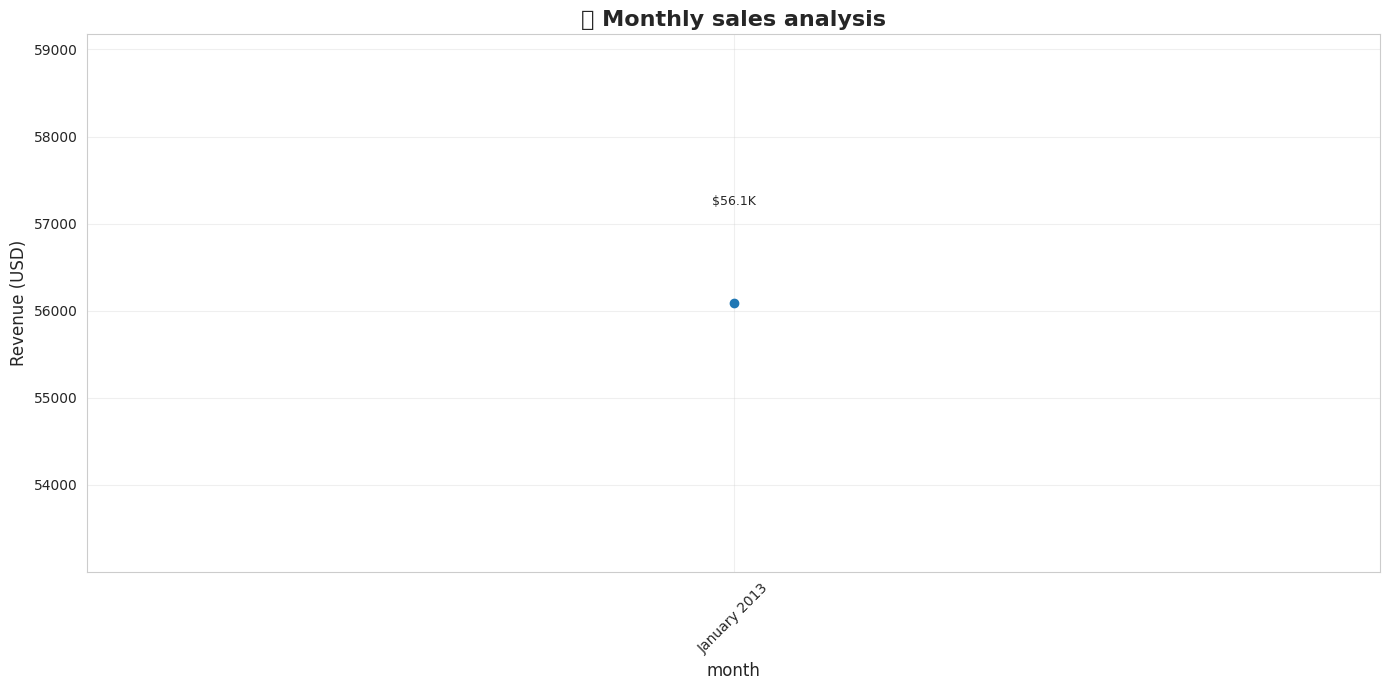


📊 نمو المبيعات الشهري:
Month_Name  Total_Revenue  MoM_Growth
   January       56089.07         NaN


In [26]:
# إعداد الرسم البياني
plt.figure(figsize=(14, 7))
sns.set_style("whitegrid")

# تجميع المبيعات الشهرية
monthly_sales = merged_df.groupby(['Year', 'Month', 'Month_Name'])['Total_Revenue'].sum().reset_index()
monthly_sales = monthly_sales.sort_values(['Year', 'Month'])

# رسم المبيعات الشهرية
plt.plot(monthly_sales['Month_Name'] + ' ' + monthly_sales['Year'].astype(str),
         monthly_sales['Total_Revenue'],
         marker='o',
         linewidth=2.5,
         color='#1f77b4')

# إعداد الرسم
plt.title('📈 Monthly sales analysis', fontsize=16, fontweight='bold')
plt.xlabel('month', fontsize=12)
plt.ylabel('Revenue (USD)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# إضافة قيم على الرسم
for i, row in monthly_sales.iterrows():
    plt.text(i, row['Total_Revenue'] * 1.02,
             f"${row['Total_Revenue']/1000:,.1f}K",
             ha='center',
             fontsize=9)

plt.tight_layout()
plt.show()

# حساب معدل النمو الشهري
monthly_sales['Prev_Month_Revenue'] = monthly_sales['Total_Revenue'].shift(1)
monthly_sales['MoM_Growth'] = ((monthly_sales['Total_Revenue'] - monthly_sales['Prev_Month_Revenue']) / monthly_sales['Prev_Month_Revenue']) * 100

print("\n📊 نمو المبيعات الشهري:")
print(monthly_sales[['Month_Name', 'Total_Revenue', 'MoM_Growth']].to_string(index=False))

/tmp/ipython-input-1377823318.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(x='Quantity', y='Stock_Item', data=top_products, palette='Blues_r', ax=ax1)
/tmp/ipython-input-1377823318.py:33: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


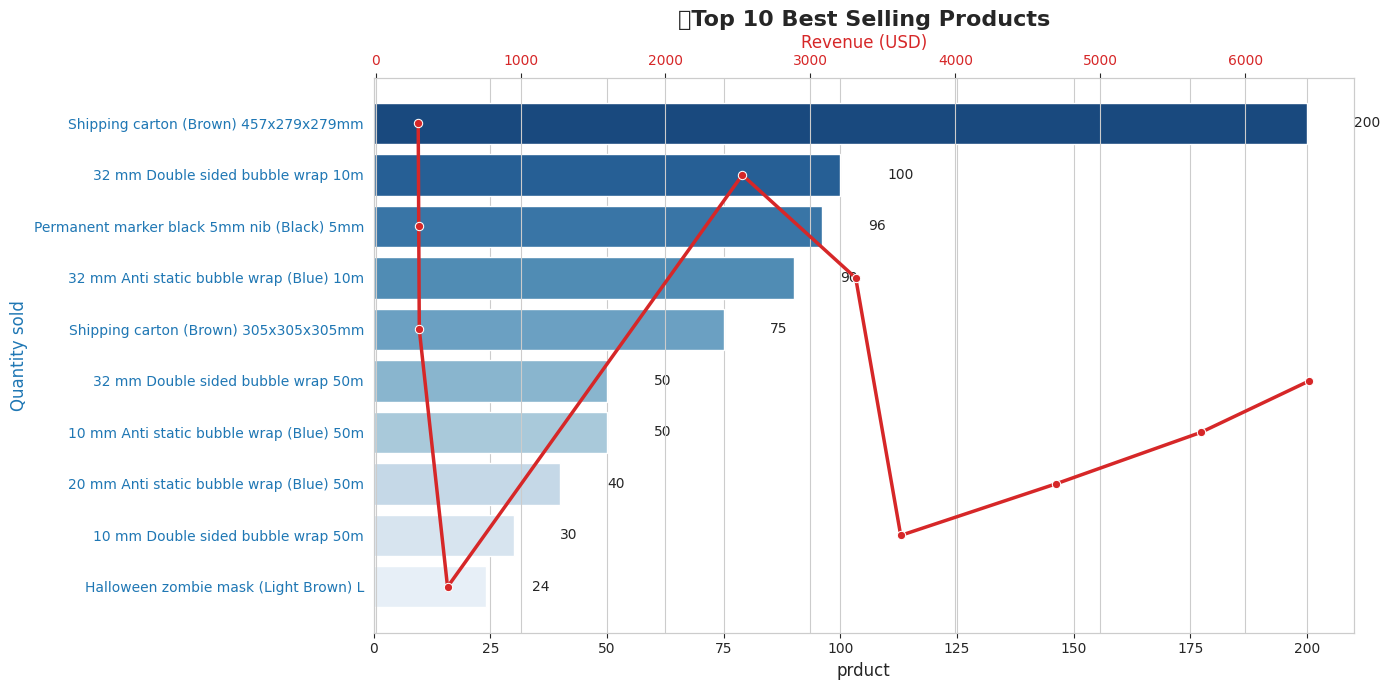


📊 تحليل المنتجات الأعلى مبيعًا:
                                Stock_Item  Quantity  Total_Revenue  Profit
     Shipping carton (Brown) 457x279x279mm       200         294.40   136.0
        32 mm Double sided bubble wrap 10m       100        2530.00  1210.0
Permanent marker black 5mm nib (Black) 5mm        96         298.08    96.0
  32 mm Anti static bubble wrap (Blue) 10m        90        3312.00  1440.0
     Shipping carton (Brown) 305x305x305mm        75         301.88   120.0
        32 mm Double sided bubble wrap 50m        50        6440.00  2650.0
  10 mm Anti static bubble wrap (Blue) 50m        50        5692.50  2700.0
  20 mm Anti static bubble wrap (Blue) 50m        40        4692.00  1880.0
        10 mm Double sided bubble wrap 50m        30        3622.50  1470.0
     Halloween zombie mask (Light Brown) L        24         496.80   -24.0


In [20]:
# تجميع البيانات حسب المنتج
top_products = merged_df.groupby('Stock_Item').agg({
    'Quantity': 'sum',
    'Total_Revenue': 'sum',
    'Profit': 'sum'
}).reset_index().sort_values('Quantity', ascending=False).head(10)

# إعداد الرسم البياني
fig, ax1 = plt.subplots(figsize=(14, 7))

# رسم الكمية
color = 'tab:blue'
ax1.set_xlabel('prduct', fontsize=12)
ax1.set_ylabel('Quantity sold', color=color, fontsize=12)
ax1 = sns.barplot(x='Quantity', y='Stock_Item', data=top_products, palette='Blues_r', ax=ax1)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title('🏆Top 10 Best Selling Products', fontsize=16, fontweight='bold')

# إضافة قيم الكمية على الأشرطة
for p in ax1.patches:
    width = p.get_width()
    ax1.text(width + 10, p.get_y() + p.get_height()/2, f'{int(width):,}',
             ha='left', va='center', fontsize=10)

# إعداد محور ثانوي للإيرادات
ax2 = ax1.twiny()
color = 'tab:red'
ax2.set_xlabel('Revenue (USD)', color=color, fontsize=12)
ax2 = sns.lineplot(x='Total_Revenue', y='Stock_Item', data=top_products,
                  color=color, marker='o', linewidth=2.5, ax=ax2)
ax2.tick_params(axis='x', labelcolor=color)

fig.tight_layout()
plt.show()

print("\n📊 تحليل المنتجات الأعلى مبيعًا:")
print(top_products[['Stock_Item', 'Quantity', 'Total_Revenue', 'Profit']].to_string(index=False))

/tmp/ipython-input-2255644207.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Total_Revenue', y='Employee', data=employee_perf.head(10),
/tmp/ipython-input-2255644207.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Avg_Revenue_Per_Order', y='Employee', data=employee_perf.head(10),
/tmp/ipython-input-2255644207.py:34: UserWarning: Glyph 128101 (\N{BUSTS IN SILHOUETTE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128101 (\N{BUSTS IN SILHOUETTE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


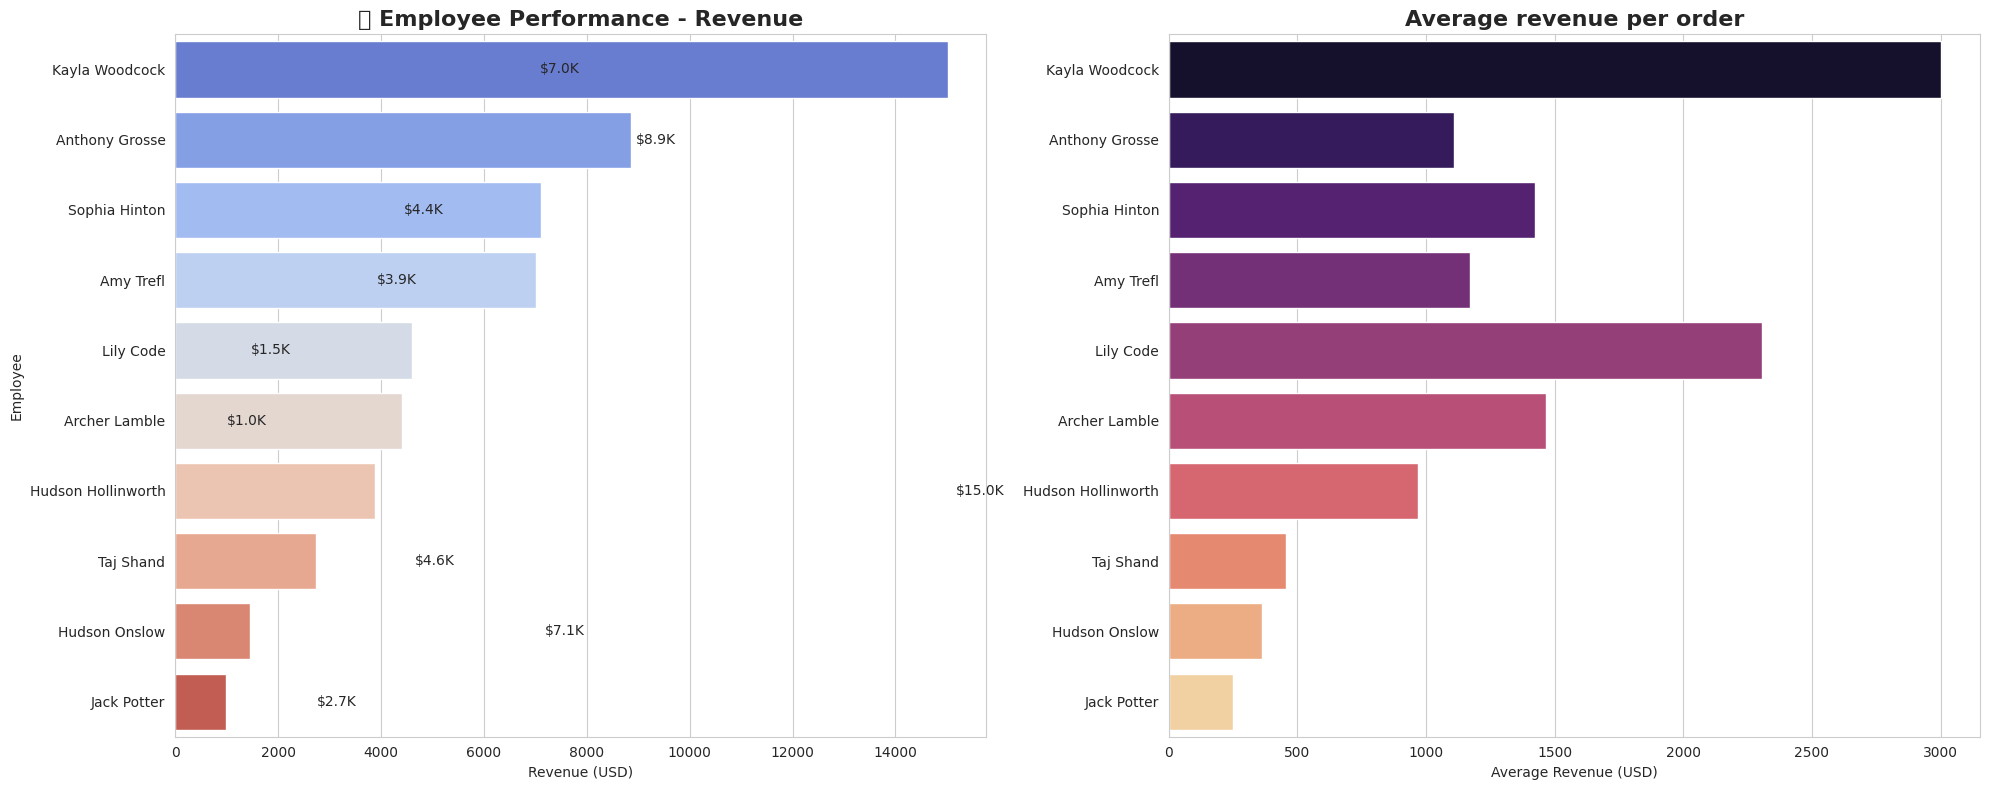


📊 تحليل أداء الموظفين:
          Employee  Total_Revenue  WWI_Invoice_ID  Avg_Revenue_Per_Order  Profit
    Kayla Woodcock       15016.70               5            3003.340000  5861.0
    Anthony Grosse        8865.93               8            1108.241250  4491.5
     Sophia Hinton        7118.50               5            1423.700000  3101.0
         Amy Trefl        7017.30               6            1169.550000  3118.0
         Lily Code        4609.20               2            2304.600000  2230.5
     Archer Lamble        4401.28               3            1467.093333  1827.0
Hudson Hollinworth        3875.50               4             968.875000  1584.0
         Taj Shand        2736.31               6             456.051667  1091.0
     Hudson Onslow        1453.60               4             363.400000   663.0
       Jack Potter         994.75               4             248.687500   578.5


In [21]:
# تجميع البيانات حسب الموظف
employee_perf = merged_df.groupby('Employee').agg({
    'Total_Revenue': 'sum',
    'Quantity': 'sum',
    'WWI_Invoice_ID': 'nunique',
    'Profit': 'sum'
}).reset_index().sort_values('Total_Revenue', ascending=False)

# حساب متوسط الإيرادات لكل طلبية
employee_perf['Avg_Revenue_Per_Order'] = employee_perf['Total_Revenue'] / employee_perf['WWI_Invoice_ID']

# إعداد الرسم البياني
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# الرسم البياني 1: الإيرادات والطلبيات
sns.barplot(x='Total_Revenue', y='Employee', data=employee_perf.head(10),
            palette='coolwarm', ax=ax1)
ax1.set_title('👥 Employee Performance - Revenue', fontsize=16, fontweight='bold')
ax1.set_xlabel('Revenue (USD)')
ax1.set_ylabel('Employee')

# إضافة قيم على الأشرطة
for i, row in employee_perf.head(10).iterrows():
    ax1.text(row['Total_Revenue'] * 1.01, i, f"${row['Total_Revenue']/1000:,.1f}K",
             va='center', fontsize=10)

# الرسم البياني 2: متوسط الإيرادات لكل طلبية
sns.barplot(x='Avg_Revenue_Per_Order', y='Employee', data=employee_perf.head(10),
            palette='magma', ax=ax2)
ax2.set_title('Average revenue per order', fontsize=16, fontweight='bold')
ax2.set_xlabel('Average Revenue (USD)')
ax2.set_ylabel('')

plt.tight_layout()
plt.show()

print("\n📊 تحليل أداء الموظفين:")
print(employee_perf[['Employee', 'Total_Revenue', 'WWI_Invoice_ID',
                    'Avg_Revenue_Per_Order', 'Profit']].head(10).to_string(index=False))

/tmp/ipython-input-2052032102.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(x='Profit_Margin', y='Stock_Item', data=top_margin, palette='Greens_r')
/tmp/ipython-input-2052032102.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(x='Profit', y='Stock_Item', data=top_profit, palette='Reds_r')
/tmp/ipython-input-2052032102.py:40: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2052032102.py:40: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2052032102.py:40: UserWarning: Tight layout not applied. tight_layout cannot make A

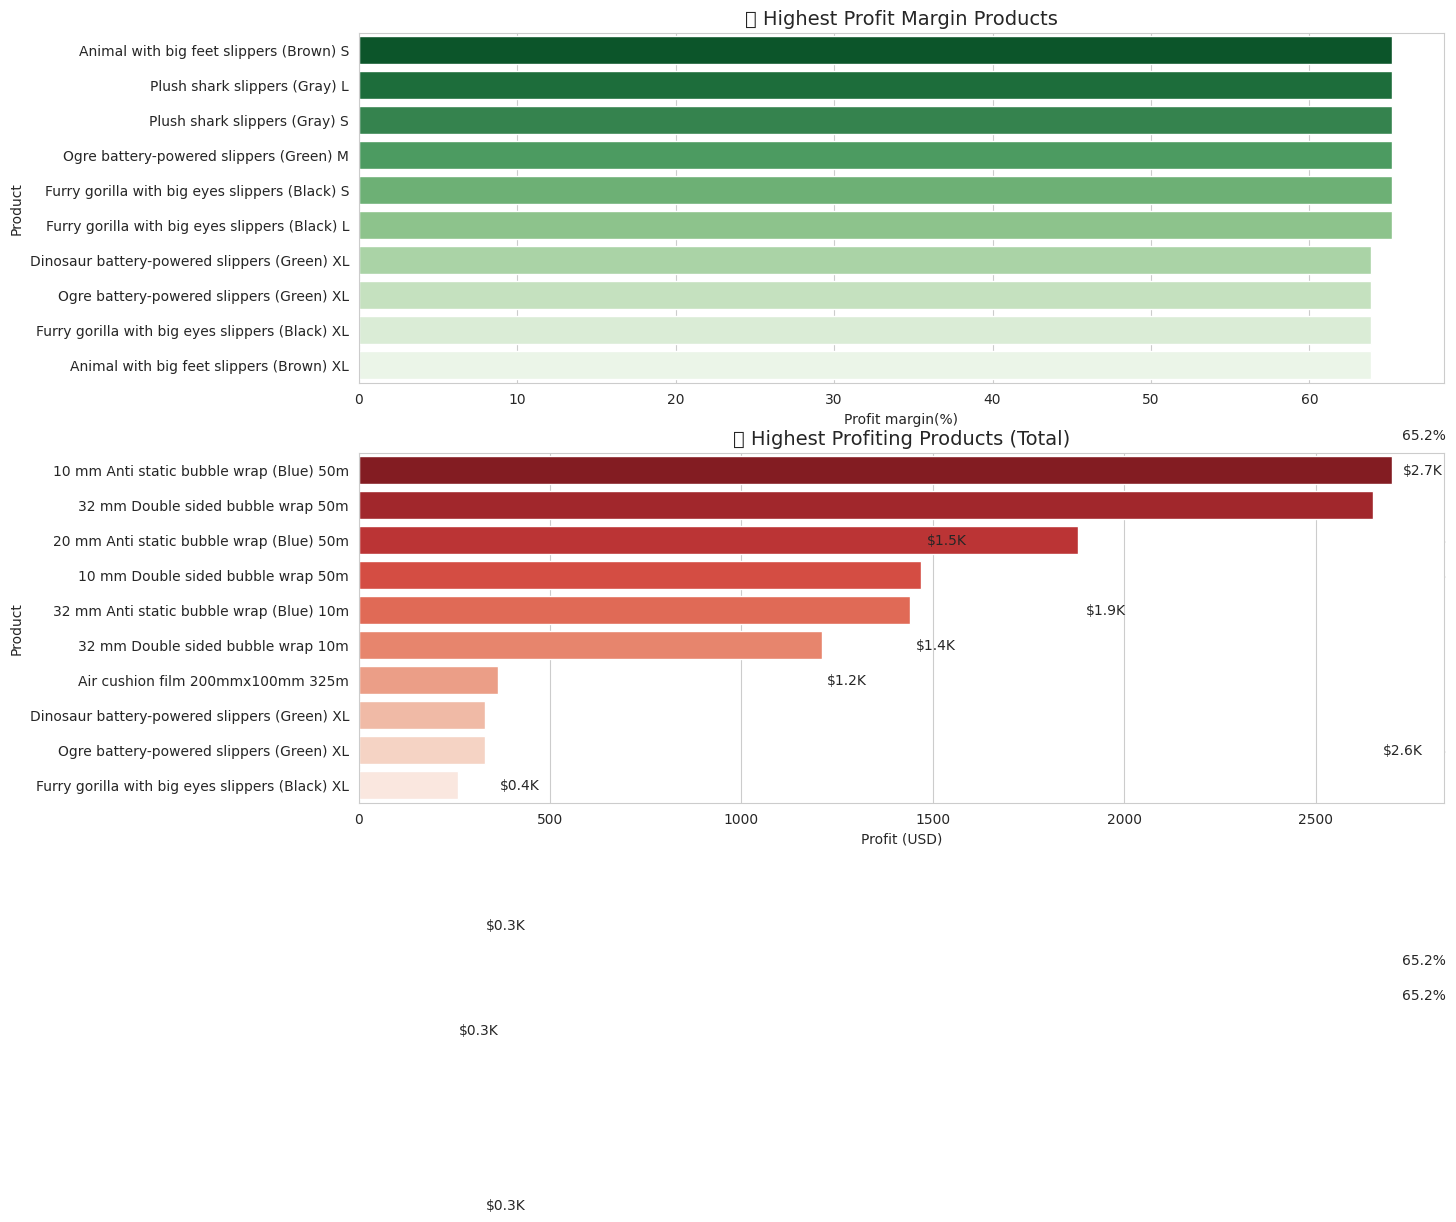


📊 تحليل هوامش الربح:
أعلى 5 منتجات هامش ربح:
                                    Stock_Item  Profit_Margin  Total_Revenue
       Animal with big feet slippers (Brown) S      65.217391          294.4
                 Plush shark slippers (Gray) L      65.217391          184.0
                 Plush shark slippers (Gray) S      65.217391          331.2
       Ogre battery-powered slippers (Green) M      65.217391          331.2
Furry gorilla with big eyes slippers (Black) S      65.217391          184.0

أعلى 5 منتجات ربحًا (إجمالي):
                              Stock_Item  Profit  Total_Revenue
10 mm Anti static bubble wrap (Blue) 50m  2700.0         5692.5
      32 mm Double sided bubble wrap 50m  2650.0         6440.0
20 mm Anti static bubble wrap (Blue) 50m  1880.0         4692.0
      10 mm Double sided bubble wrap 50m  1470.0         3622.5
32 mm Anti static bubble wrap (Blue) 10m  1440.0         3312.0


In [23]:
# حساب هامش الربح
merged_df['Profit_Margin'] = (merged_df['Profit'] / merged_df['Total_Revenue']) * 100

# تحليل هامش الربح حسب المنتج
product_profit = merged_df.groupby('Stock_Item').agg({
    'Profit_Margin': 'mean',
    'Total_Revenue': 'sum',
    'Profit': 'sum'
}).reset_index().sort_values('Profit_Margin', ascending=False)

# إعداد الرسم البياني
plt.figure(figsize=(14, 10))

# الرسم البياني 1: أعلى المنتجات هامش ربح
plt.subplot(2, 1, 1)
top_margin = product_profit.head(10)
ax1 = sns.barplot(x='Profit_Margin', y='Stock_Item', data=top_margin, palette='Greens_r')
plt.title('📈 Highest Profit Margin Products', fontsize=14)
plt.xlabel('Profit margin(%)')
plt.ylabel('Product')

# إضافة قيم على الأشرطة
for i, row in top_margin.iterrows():
    ax1.text(row['Profit_Margin'] * 1.01, i, f"{row['Profit_Margin']:.1f}%",
             va='center', fontsize=10)

# الرسم البياني 2: أعلى المنتجات ربحًا (إجمالي)
plt.subplot(2, 1, 2)
top_profit = product_profit.sort_values('Profit', ascending=False).head(10)
ax2 = sns.barplot(x='Profit', y='Stock_Item', data=top_profit, palette='Reds_r')
plt.title('💰 Highest Profiting Products (Total)', fontsize=14)
plt.xlabel('Profit (USD)')
plt.ylabel('Product')

# إضافة قيم على الأشرطة
for i, row in top_profit.iterrows():
    ax2.text(row['Profit'] * 1.01, i, f"${row['Profit']/1000:.1f}K",
             va='center', fontsize=10)

plt.tight_layout()
plt.show()

print("\n📊 تحليل هوامش الربح:")
print("أعلى 5 منتجات هامش ربح:")
print(product_profit[['Stock_Item', 'Profit_Margin', 'Total_Revenue']].head().to_string(index=False))
print("\nأعلى 5 منتجات ربحًا (إجمالي):")
print(product_profit.sort_values('Profit', ascending=False)[['Stock_Item', 'Profit', 'Total_Revenue']].head().to_string(index=False))